# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

## Изучение данных

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression 

In [2]:
path_1 = '/Users/ivanbodrenkov/Yandex.Disk.localized/Яндекс Практикум/6. Введение в машинное обучение/Проект/users_behavior.csv'
path_2 = 'https://code.s3.yandex.net/datasets/users_behavior.csv'
path_3 = 'C:/Users/bodrenkov_ia/Desktop/Project/users_behavior.csv'
path_4 = '/datasets/users_behavior.csv'

if os.path.exists(path_1):
    data = pd.read_csv(path_1, sep = ',')
elif os.path.exists(path_2):
    data = pd.read_csv(path_2, sep = ',')
elif os.path.exists(path_3):
    data = pd.read_csv(path_3, sep = ',')
elif os.path.exists(path_4):
    data = pd.read_csv(path_4, sep = ',')
else:
    print('Что-то пошло не так!')

In [3]:
display(data.head(10))
data.info()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
5,58.0,344.56,21.0,15823.37,0
6,57.0,431.64,20.0,3738.90,1
7,15.0,132.40,6.0,21911.60,0
8,7.0,43.39,3.0,2538.67,1
9,90.0,665.41,38.0,17358.61,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


Датасет содержит следующую информацию:
* сalls — количество звонков,
* minutes — суммарная длительность звонков в минутах,
* messages — количество sms-сообщений,
* mb_used — израсходованный интернет-трафик в Мб,
* is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

Гистограммы данных датасета:


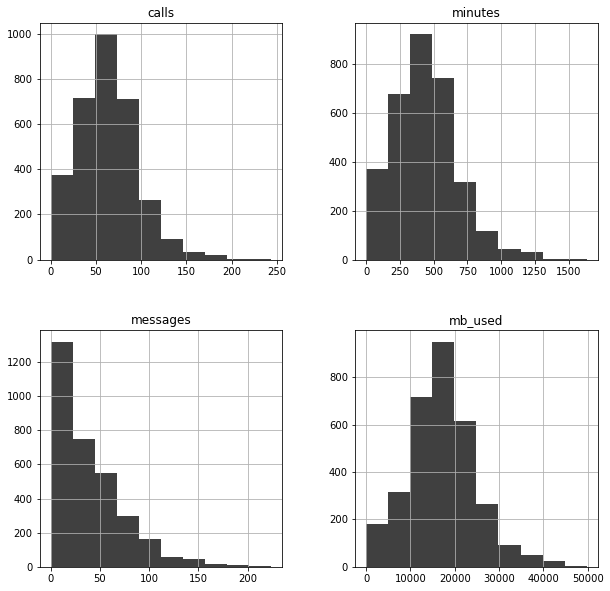

Соотношение кол-ва пользователей тарифа ultra (1) и smart (0):


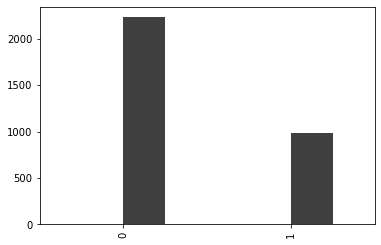

In [4]:
print('Гистограммы данных датасета:')
data.drop('is_ultra', axis = 1).hist(figsize = (10, 10), color = 'black', alpha = 0.75)
plt.show()

print('Соотношение кол-ва пользователей тарифа ultra (1) и smart (0):')
data.pivot_table(index = 'is_ultra', 
                 values = 'calls', 
                 aggfunc = 'count').reset_index().plot(kind = 'bar', 
                                                       legend = False, 
                                                       color = 'black', 
                                                       alpha = 0.75)
plt.show()

Матрица корреляции для датасета:


,calls,minutes,messages,mb_used,is_ultra
calls,1.000000,0.982083,0.177385,0.286442,0.207122
minutes,0.982083,1.000000,0.173110,0.280967,0.206955
messages,0.177385,0.173110,1.000000,0.195721,0.203830
mb_used,0.286442,0.280967,0.195721,1.000000,0.198568
is_ultra,0.207122,0.206955,0.203830,0.198568,1.000000


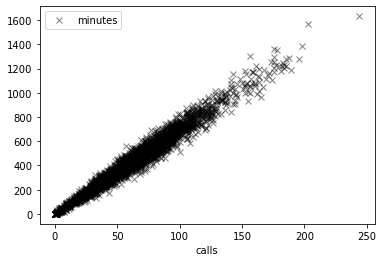

In [5]:
print('Матрица корреляции для датасета:')
display(data.corr())

data.plot(x = 'calls', y = 'minutes', style = 'x', color = 'black', alpha = 0.5)
plt.show()

### Промежуточный вывод
Написано описание данных датасета. Показаны гистограммы данных в датасете, построена матрица корреляции. Значительная корреляция среди параметров датасета есть только между количеством звонков и суммарным количеством минут разговора.

## Разделение данных на выборки

In [6]:
data_train, data_valid_and_test = train_test_split(data, test_size=0.4, random_state=12345)
data_valid, data_test = train_test_split(data_valid_and_test, test_size=0.5, random_state=12345)

features_train = data_train.drop('is_ultra', axis = 1)
target_train = data_train['is_ultra']
features_valid = data_valid.drop('is_ultra', axis = 1)
target_valid = data_valid['is_ultra']
features_test = data_test.drop('is_ultra', axis = 1)
target_test = data_test['is_ultra']

print('Выборки созданы из исходного датасета в соотношении 3/1/1:')
print('Размер датафрейма обучающей выборки:', data_train.shape[0])
print('Размер датафрейма валидационной выборки:', data_valid.shape[0])
print('Размер датафрейма тестовой выборки:', data_test.shape[0])

Выборки созданы из исходного датасета в соотношении 3/1/1:
Размер датафрейма обучающей выборки: 1928
Размер датафрейма валидационной выборки: 643
Размер датафрейма тестовой выборки: 643


## Исследование моделей

### Решающее дерево

,depth,accuracy_score
0,1.0,0.754277
1,2.0,0.782271
2,3.0,0.785381
3,4.0,0.779160
4,5.0,0.779160
5,6.0,0.783826
6,7.0,0.782271
7,8.0,0.779160
8,9.0,0.782271
9,10.0,0.774495


<AxesSubplot:xlabel='depth'>

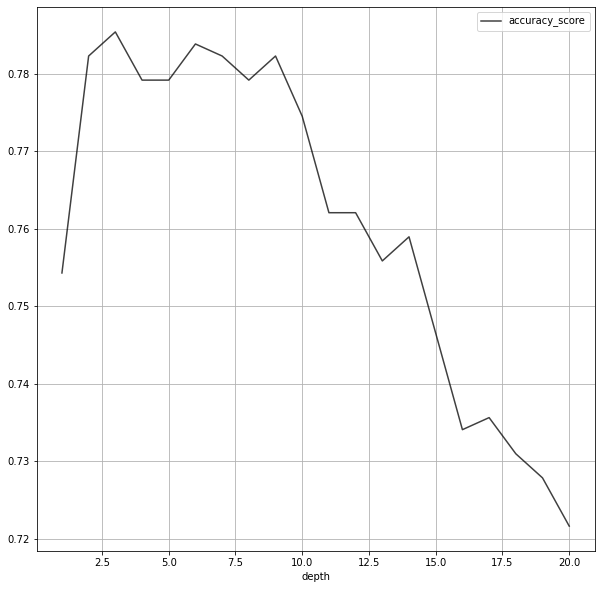

In [7]:
depths_scores = pd.DataFrame(columns = ['depth', 'accuracy_score'])
for depth in range (1, 21):
    model_1 = DecisionTreeClassifier(random_state = 12345, max_depth = depth)
    model_1.fit(features_train, target_train)
    predictions_valid = model_1.predict(features_valid)
    score = accuracy_score(target_valid, predictions_valid)    
    depths_scores.loc[len(depths_scores)] = [depth, score]
    
display(depths_scores)
depths_scores.plot(x = 'depth', 
                   y = 'accuracy_score', 
                   color = 'black', 
                   alpha = 0.75, 
                   figsize = (10, 10), 
                   grid = True)

### Случайный лес

,n_estimators,accuracy_score
0,1.0,0.710731
1,2.0,0.763608
2,3.0,0.738725
3,4.0,0.771384
4,5.0,0.749611
5,6.0,0.780715
6,7.0,0.768274
7,8.0,0.782271
8,9.0,0.772939
9,10.0,0.785381


<AxesSubplot:xlabel='n_estimators'>

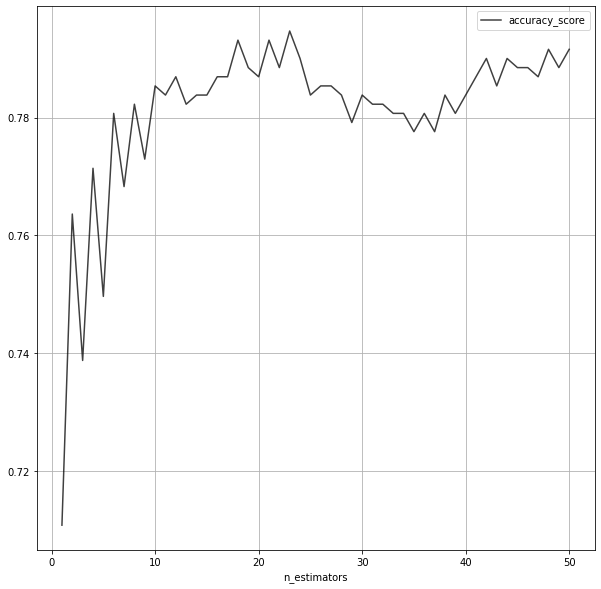

In [8]:
est_scores = pd.DataFrame(columns = ['n_estimators', 'accuracy_score'])
for est in range (1, 51):
    model_2 = RandomForestClassifier(random_state = 12345, n_estimators = est)
    model_2.fit(features_train, target_train)
    predictions_valid = model_2.predict(features_valid)
    score = accuracy_score(target_valid, predictions_valid)    
    est_scores.loc[len(est_scores)] = [est, score]
    
display(est_scores)
est_scores.plot(x = 'n_estimators', 
                y = 'accuracy_score', 
                color = 'black', 
                alpha = 0.75, 
                figsize = (10, 10), 
                grid = True)

,depth,accuracy_score
0,1.0,0.774495
1,2.0,0.783826
2,3.0,0.788491
3,4.0,0.790047
4,5.0,0.794712
5,6.0,0.800933
6,7.0,0.800933
7,8.0,0.800933
8,9.0,0.794712
9,10.0,0.794712


<AxesSubplot:xlabel='depth'>

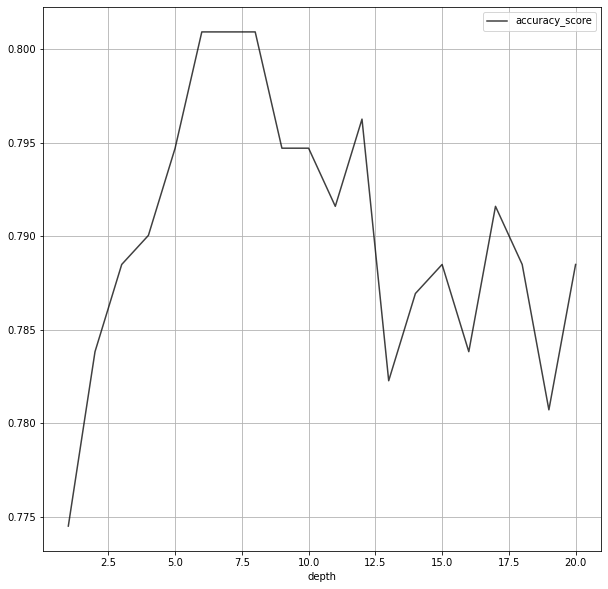

In [9]:
depths_scores = pd.DataFrame(columns = ['depth', 'accuracy_score'])
for depth in range (1, 21):
    model_3 = RandomForestClassifier(random_state = 12345, max_depth = depth)
    model_3.fit(features_train, target_train)
    predictions_valid = model_3.predict(features_valid)
    score = accuracy_score(target_valid, predictions_valid)    
    depths_scores.loc[len(depths_scores)] = [depth, score]
    
display(depths_scores)
depths_scores.plot(x = 'depth', 
                   y = 'accuracy_score', 
                   color = 'black', 
                   alpha = 0.75, 
                   figsize = (10, 10), 
                   grid = True)

,max_features,accuracy_score
0,sqrt,0.785381
1,log2,0.785381


<AxesSubplot:xlabel='max_features'>

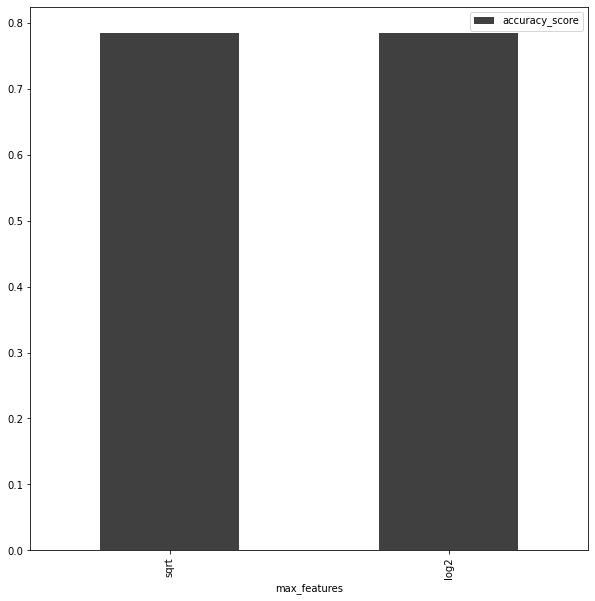

In [10]:
max_features = ['sqrt', 'log2']
max_features_scores = pd.DataFrame(columns = ['max_features', 'accuracy_score'])

for max_feature in max_features:
    model_4 = RandomForestClassifier(random_state = 12345, max_features = max_feature)
    model_4.fit(features_train, target_train)
    predictions_valid = model_4.predict(features_valid)
    score = accuracy_score(target_valid, predictions_valid)    
    max_features_scores.loc[len(max_features_scores)] = [max_feature, score]
    
display(max_features_scores)
max_features_scores.plot(x = 'max_features', 
                         y = 'accuracy_score', 
                         color = 'black', 
                         alpha = 0.75, 
                         figsize = (10, 10), 
                         grid = False, 
                         kind = 'bar')

### Логистическая регрессия

,penalty,accuracy_score
0,l2,0.710731
1,none,0.755832


<AxesSubplot:xlabel='penalty'>

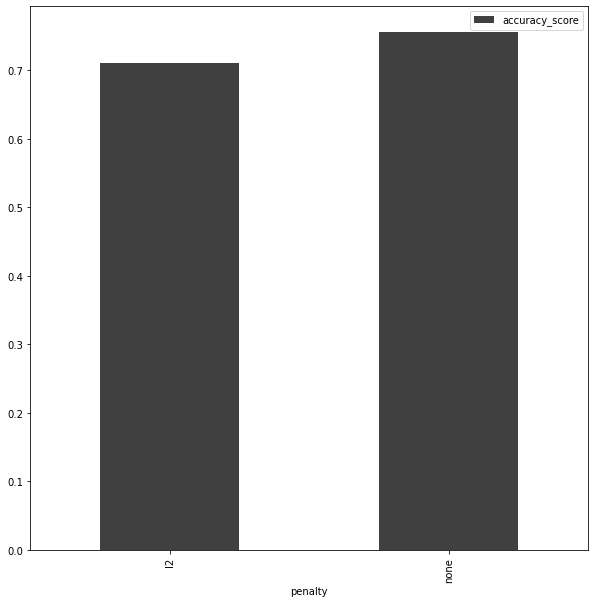

In [11]:
penaltys = ['l2', 'none']
penaltys_scores = pd.DataFrame(columns = ['penalty', 'accuracy_score'])

for penalty in penaltys:
    model_5 = LogisticRegression(random_state = 12345, solver = 'lbfgs', max_iter = 1000, penalty = penalty) 
    model_5.fit(features_train, target_train)
    predictions_valid = model_5.predict(features_valid)
    score = accuracy_score(target_valid, predictions_valid)    
    penaltys_scores.loc[len(penaltys_scores)] = [penalty, score]
    
display(penaltys_scores)
penaltys_scores.plot(x = 'penalty', 
                     y = 'accuracy_score', 
                     color = 'black', 
                     alpha = 0.75, 
                     figsize = (10, 10), 
                     grid = False, 
                     kind = 'bar')

,tolerance,accuracy_score
0,1.000000e-01,0.710731
1,1.000000e-02,0.710731
2,1.000000e-03,0.710731
3,1.000000e-04,0.710731
4,1.000000e-05,0.710731
5,1.000000e-06,0.710731
6,1.000000e-07,0.710731


<AxesSubplot:xlabel='tolerance'>

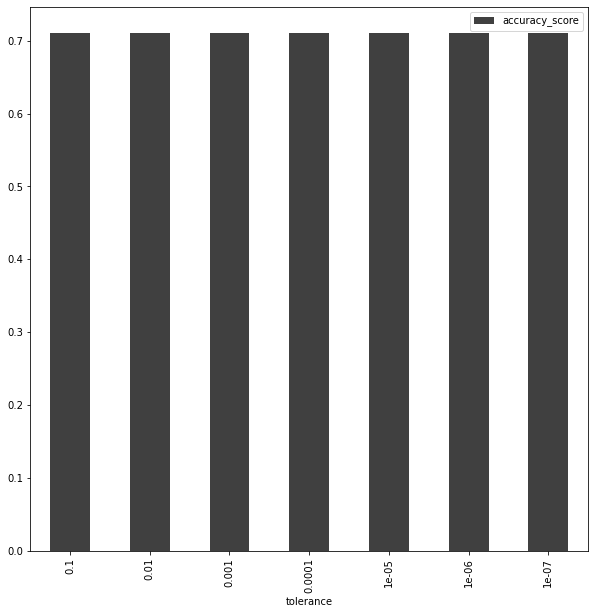

In [12]:
tolerances = [0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001, 0.0000001]
tolerance_scores = pd.DataFrame(columns = ['tolerance', 'accuracy_score'])

for tol in tolerances:
    model_6 = LogisticRegression(random_state = 12345, solver = 'lbfgs', max_iter = 1000, tol = tol) 
    model_6.fit(features_train, target_train)
    predictions_valid = model_6.predict(features_valid)
    score = accuracy_score(target_valid, predictions_valid)  
    tolerance_scores.loc[len(tolerance_scores)] = [tol, score]
    
display(tolerance_scores)
tolerance_scores.plot(x = 'tolerance', 
                      y = 'accuracy_score', 
                      color = 'black', 
                      alpha = 0.75, 
                      figsize = (10, 10), 
                      grid = False, 
                      kind = 'bar')

### Промежуточные выводы

**Решающее дерево** на обучающей выборке дает результат accuracy_score выше 0.75. Наилучшее значение варьируемого гиперпараметра (depth) - 3, accuracy_score = 0.785381.

**Случайный лес** на обучающей выборке дает результат accuracy_score выше 0.75. Варьирование параметра n_estimators также дает высокие результаты показателя accuracy_score. Варьирование max_features не дало рекордных результатов, при значении 'none' программа выдает ошибку. Наилучшее значение варьируемого гиперпараметра (depth) - 6-8, **accuracy_score = 0.800933**. Три гиперпараметра исследованы именно для этой модели, так как она дает наилучшие результаты из представленных в исследовании.

**Логистическая регрессия** на обучающей выборке дает результат accuracy_score выше 0.75. Варьировалось два параметра: tol, penalty. Для вариации по tol значение penalty стояло по умолчанию (l2). Варьирование tol не дает изменения результата, значения penalty 'l1' и 'elasticnet' не дают работоспособных моделей (программа выдает ошибку). Наилучшее значение варьируемого гиперпараметра (penalty) - 'none', accuracy_score = 0.755832.

Наилучшие показатели accuracy_score на обучающей выборке показывает модель типа **случайный лес** cо значением гиперпараметра **depth = 6-8**. Проверка модели на тестовой выборке будет производиться на этой модели. 

|Модель|Варьируемый гиперпараметр|Наилучший результат accuracy_score|Значение гиперпараметра|
|:-|:-:|:-:|:-:|
|Решающее дерево|depth|0.785|3|
|Случайный лес|n_estimators|0.795|22|
|Случайный лес|max_features|0.785|sqrt/log2|
|Случайный лес|depth|**0.801**|5-7|
|Логистическая регрессия|penalty|0.756|l2|
|Логистическая регрессия|tolerance|0.711|1e-7 - 1e-1|

## Проверка модели на тестовой выборке

In [13]:
model_final = RandomForestClassifier(random_state = 12345, max_depth = 7)
model_final.fit(features_train, target_train)
predictions_test = model_final.predict(features_test)
score = accuracy_score(target_test, predictions_test)
print('accuracy_score =', score)

accuracy_score = 0.80248833592535


## Проверка модели на адекватность

Довольно сложно судить об адекватности модели не обладая пока что необходимыми для этого знаниями. Но в теории курса было сказано, что на адекватность и вменяемость модели проверяются в сравнении со случайной моделью. У нас всего 2 варианта ответа на вопрос о рекомендуемом тарифе. Случайная модель должна в таком случае иметь accuracy_score = 0.5. У всех моделей этот показатель выше, так что я считаю, что модели можно считать адекватными.

## Общий вывод
Наилучшая из исследованных моделей - **случайный лес** с гиперпараметром **depth = 6-8**. Данная модель на обучающей выборке показала accuracy_score = 0.800933, а на тестовой выборке accuracy_score = 0.802488.